#  Part 3.2 Document Classification 
#  Includes LDiA, T-SNE

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pandas as pd
import numpy as np
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDiA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import metrics

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import ward, dendrogram

In [3]:
#Load corpus files from json objects

with open('///.json', 'r') as read_file:
    corpus_wLabels=json.load(read_file)
    
with open('///.json', 'r') as read_file:
    corpus_wTitles=json.load(read_file)
    
vocab_dir='////vocab.txt'
file=open(vocab_dir, 'r')
vocab=file.read()
file.close()
print('Number of documents in corpus: ', len(corpus_wLabels))

Number of documents in corpus:  546


In [4]:
#Load lists of texts, titles, labels, categories
#remove additional stopwords with high occurrance but low value

corp_text=list(corpus_wLabels.keys())
labels=list(corpus_wLabels.values())
titles=list(corpus_wTitles.keys())
X_corp=[]
corp_words=Counter()

le=LabelEncoder()
y_labels=le.fit_transform(labels)

stopwords=['however','whether','even','may','given','one','also','way', 'every','simply','terms','kind','claim',
           'would','two','first','seems','seem','false','might','without','simple', 'like','see','view','example',
          'neutral', 'philosophy', 'philosophical', 'russell','whitehead', 'case','must','thus', 'bolzano']

for text in corp_text:
    tokens=text.split()
    tokens=[w for w in tokens if not w in stopwords]
    corp_words.update(tokens)
    wtokens=' '.join(tokens)
    X_corp.append(wtokens)

print('Full corpus filtered vocab size: %d' % len(corp_words))

Full corpus filtered vocab size: 23612


# K-Means Clustering:
## Document Consolidation

## Term-Document CountVectorizer Document Clustering

Matrix Shape:  (546, 100)
Explained variance of the SVD step: 81%


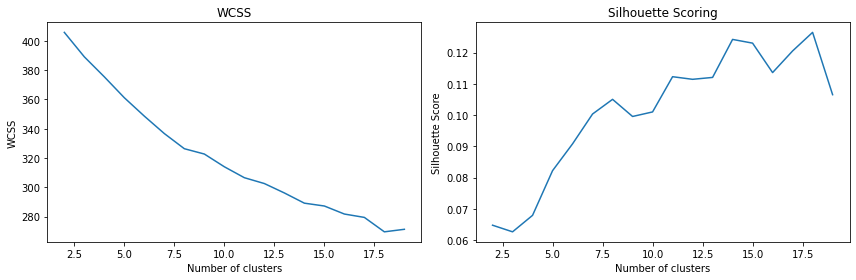

In [6]:
#Analysis 1, Kmeans Document Grouping using term-document matrix 
#Count Vectorizer DOCUMENTS 2
#Estimate best number of clusters using Silhouette Scoring, Elbow method

CV=CountVectorizer()
X_cv=CV.fit_transform(X_corp)

svd=TruncatedSVD(n_components=100)
normalizer=Normalizer(copy=False)
lsa=make_pipeline(svd,normalizer)
X=lsa.fit_transform(X_cv)

print('Matrix Shape: ', X.shape)
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

wcss=[]
ss=[]
for i in range(2,20):
    km=KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1)
    km.fit(X)
    ss.append(metrics.silhouette_score(X, km.labels_))
    wcss.append(km.inertia_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))   
ax1.plot(range(2,20),wcss)
ax1.set_title('WCSS')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')
ax2.plot(range(2,20),ss)
ax2.set_title('Silhouette Scoring')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

In [49]:
#Build actual clusters based on optimal groupings from above EDA
#Organize Cluster document clusters into Pandas DF alongside original classification

n_clust=6
km=KMeans(n_clusters=n_clust, init='k-means++', n_init=1)
km.fit(X)

terms = CV.get_feature_names()
print()
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y_labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(y_labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(y_labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_))
print()

CV_Clusters=km.labels_
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

####
clust_num=[]
for i in range(1,n_clust+1):
    clust_num.append('cluster'+str(i))
    
clustercent_df=pd.DataFrame(original_space_centroids.T,columns=clust_num,index=terms)
corp_doc_kmeans_cv=pd.DataFrame()
cv_vecs10={}
for col in clustercent_df.columns:
    intdf=clustercent_df.nlargest(10,col)
    cvdf_vecs=list(zip(intdf.index.to_list(),intdf[col].to_list()))
    cv_vecs10[col]=[cvdf_vecs]

counter=0
for item in cv_vecs10.values():
    y,wlabel=[],[]
    counter=counter+1
    for word in item:
        for ww,wv in word:
            y.append(wv)
            wlabel.append(ww)
    cname='Cluster'+str(counter)
    cval='Score'+str(counter)
    corp_doc_kmeans_cv[cname]=wlabel
    corp_doc_kmeans_cv[cval]=y

corp_doc_kmeans_cv.head(10)


Homogeneity: 0.499
Completeness: 0.513
V-measure: 0.506
Adjusted Rand-Index: 0.375
Silhouette Coefficient: 0.087



,Cluster1,Score1,Cluster2,Score2,Cluster3,Score3,Cluster4,Score4,Cluster5,Score5,Cluster6,Score6
0,theory,0.199415,moral,0.240059,logical,0.180886,knowledge,0.421581,mental,0.280210,experience,0.377228
1,set,0.197214,theory,0.083428,logic,0.173789,know,0.126123,states,0.142051,phenomenal,0.186400
2,logic,0.173584,argument,0.077172,true,0.141677,belief,0.117704,cognitive,0.109795,experiences,0.182977
3,mathematics,0.154183,language,0.073558,propositions,0.125897,true,0.101724,mind,0.088601,content,0.147857
4,mathematical,0.127858,nature,0.068753,truth,0.117165,acquaintance,0.093123,theory,0.086971,properties,0.127643
5,secondorder,0.098640,thought,0.065628,proposition,0.111410,justification,0.089897,content,0.077617,contents,0.109122
6,numbers,0.095825,good,0.064785,theory,0.091784,justified,0.072471,properties,0.075707,states,0.086650
7,sets,0.074307,account,0.063396,sentences,0.089230,world,0.069755,consciousness,0.074037,character,0.082272
8,arithmetic,0.070144,sense,0.062886,sentence,0.072852,sense,0.069349,state,0.067466,consciousness,0.079729
9,natural,0.069915,world,0.060844,language,0.070229,doubt,0.066449,thought,0.065509,objects,0.077837


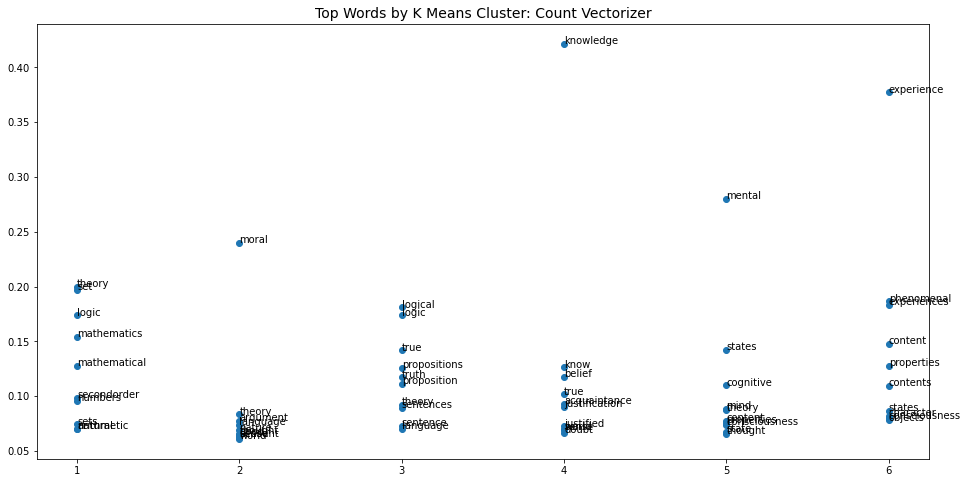

In [50]:
x,y,wlabel=[],[],[]
counter=0
for item in cv_vecs10.values():
    counter=counter+1
    for word in item:
        for ww,wv in word:
            x.append(counter)
            y.append(wv)
            wlabel.append(ww)

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x, y)
for i, txt in enumerate(wlabel):
    ax.annotate(txt, (x[i], y[i]), fontsize=10)
plt.title('Top Words by K Means Cluster: Count Vectorizer', fontsize=14)
plt.savefig('countvec.png')

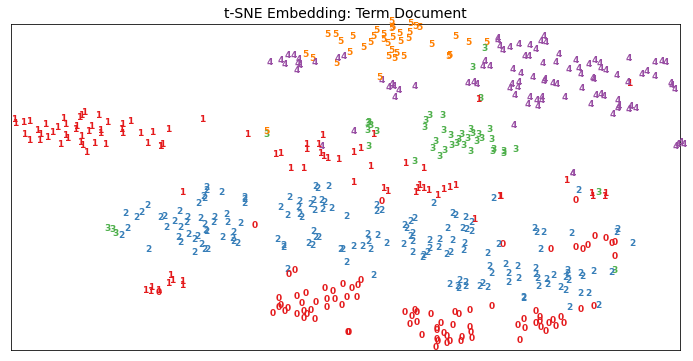

In [51]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(12,6))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(CV_Clusters[i]),color=plt.cm.Set1(CV_Clusters[i] / 10.), fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title, fontsize=14)

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne,"t-SNE Embedding: Term Document")
plt.savefig('TSNE_CV.png')

# TF-IDF Clustering

Explained variance of the SVD step: 45%
Matrix Shape:  (546, 100)


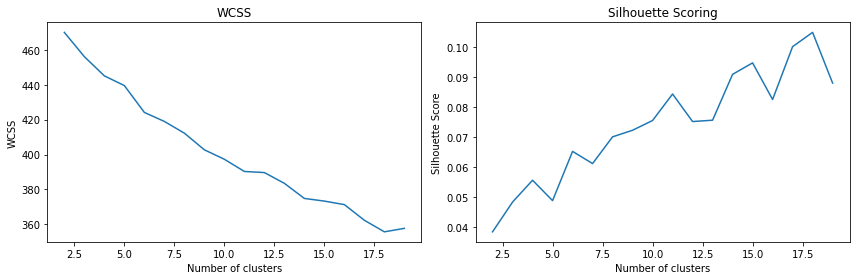

In [52]:
#TFIDF Clusters with SVD

tfidf_vec=TfidfVectorizer()
X_tfidf=tfidf_vec.fit_transform(X_corp)

svd=TruncatedSVD(n_components=100)
normalizer=Normalizer(copy=False)
lsa=make_pipeline(svd,normalizer)
X=lsa.fit_transform(X_tfidf)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
print('Matrix Shape: ', X.shape)
wcss=[]
ss=[]
for i in range(2,20):
    km=KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1)
    km.fit(X)
    ss.append(metrics.silhouette_score(X, km.labels_))
    wcss.append(km.inertia_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))   
ax1.plot(range(2,20),wcss)
ax1.set_title('WCSS')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')
ax2.plot(range(2,20),ss)
ax2.set_title('Silhouette Scoring')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

In [78]:
#Build actual clusters based on optimal groupings from above EDA
#Organize Cluster document clusters into Pandas DF alongside original classification

n_clust=6
km=KMeans(n_clusters=n_clust, init='k-means++', n_init=1)
km.fit(X)

terms = tfidf_vec.get_feature_names()
print()
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y_labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(y_labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(y_labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_))
print()

TFIDF_Clusters=km.labels_
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

####
clust_num=[]
for i in range(1,n_clust+1):
    clust_num.append('cluster'+str(i))
    
clustercent_df=pd.DataFrame(original_space_centroids.T,columns=clust_num,index=terms)
corp_doc_kmeans_tfidf=pd.DataFrame()
cv_vecs10={}
for col in clustercent_df.columns:
    intdf=clustercent_df.nlargest(10,col)
    cvdf_vecs=list(zip(intdf.index.to_list(),intdf[col].to_list()))
    cv_vecs10[col]=[cvdf_vecs]

counter=0
for item in cv_vecs10.values():
    y,wlabel=[],[]
    counter=counter+1
    for word in item:
        for ww,wv in word:
            y.append(wv)
            wlabel.append(ww)
    cname='Cluster'+str(counter)
    cval='Score'+str(counter)
    corp_doc_kmeans_tfidf[cname]=wlabel
    corp_doc_kmeans_tfidf[cval]=y

corp_doc_kmeans_tfidf.head(10)


Homogeneity: 0.538
Completeness: 0.521
V-measure: 0.529
Adjusted Rand-Index: 0.420
Silhouette Coefficient: 0.086



,Cluster1,Score1,Cluster2,Score2,Cluster3,Score3,Cluster4,Score4,Cluster5,Score5,Cluster6,Score6
0,mental,0.322296,theory,0.199548,knowledge,0.182451,logic,0.292195,propositions,0.257341,moral,0.277820
1,states,0.147401,set,0.198347,experience,0.168835,logical,0.272142,proposition,0.246613,theory,0.089903
2,cognitive,0.118870,logic,0.159037,sense,0.091603,sentences,0.102297,true,0.217124,argument,0.084458
3,content,0.103941,mathematics,0.153062,objects,0.075555,language,0.088965,truth,0.156276,language,0.084370
4,mind,0.098240,mathematical,0.124196,experiences,0.069232,theory,0.085385,theory,0.086933,good,0.075451
5,theory,0.087550,numbers,0.094738,properties,0.068927,modal,0.079931,sentence,0.077384,account,0.062024
6,representations,0.076269,secondorder,0.093643,consciousness,0.066718,true,0.077726,world,0.072172,virtue,0.060811
7,properties,0.074480,sets,0.075785,world,0.066253,truth,0.072318,fact,0.070308,nature,0.058780
8,thought,0.074124,arithmetic,0.069243,theory,0.062072,form,0.064846,sense,0.070045,thought,0.056549
9,science,0.062985,type,0.068352,phenomenal,0.061030,sentence,0.064442,possible,0.068874,natural,0.053246


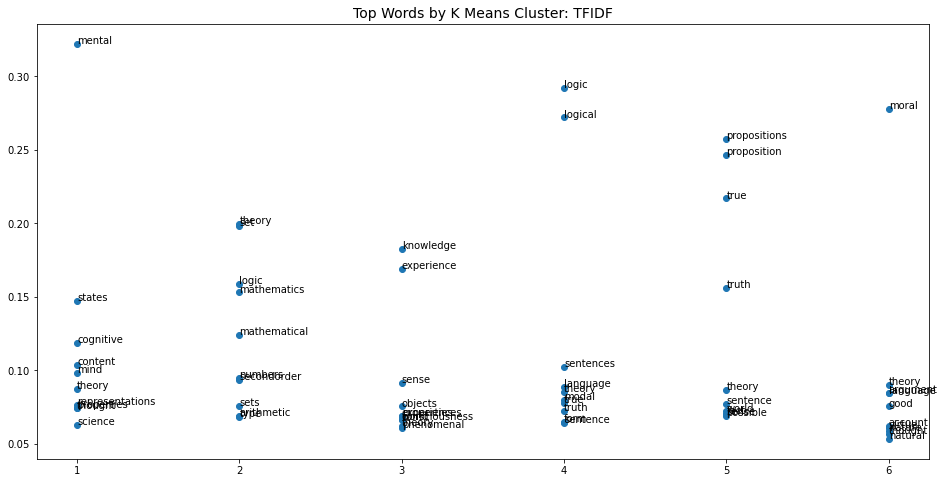

In [79]:
x,y,wlabel=[],[],[]
counter=0
for item in cv_vecs10.values():
    counter=counter+1
    for word in item:
        for ww,wv in word:
            x.append(counter)
            y.append(wv)
            wlabel.append(ww)

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x, y)
for i, txt in enumerate(wlabel):
    ax.annotate(txt, (x[i], y[i]), fontsize=10)
plt.title('Top Words by K Means Cluster: TFIDF', fontsize=14)
plt.savefig('tfidfvec.png')

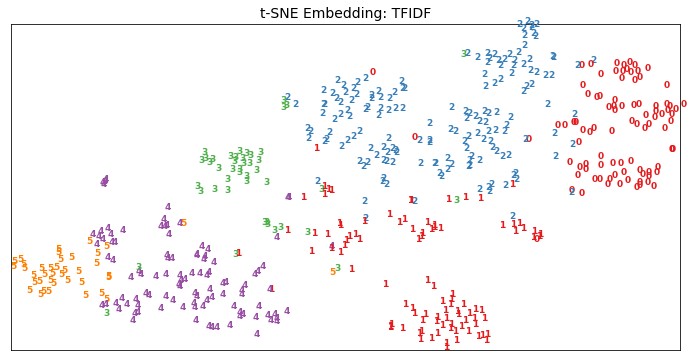

In [80]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(12,6))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(CV_Clusters[i]),color=plt.cm.Set1(CV_Clusters[i] / 10.), fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title, fontsize=14)

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne,"t-SNE Embedding: TFIDF")
plt.savefig('TSNE_TFIDF.png')

# Doc2Vec Clustering

(546, 100)


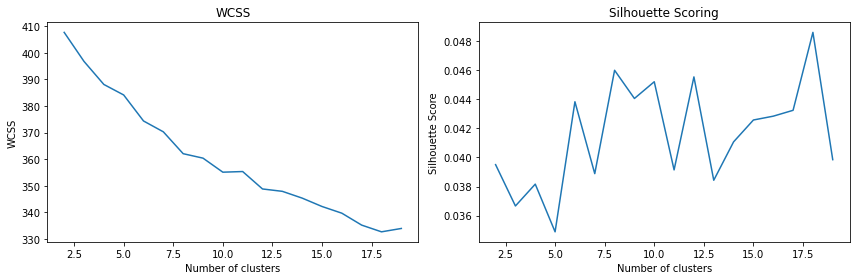

In [56]:
#Analysis 3: Doc2Vec

def tokenize_docs(X):
    word_tokens=[]
    for doc in X:
        tokens=doc.split()
        word_tokens.append(tokens)
    return word_tokens
    
X_train_tokens=tokenize_docs(X_corp)

#100 Dim
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train_tokens)]
model_100dim = Doc2Vec(documents, vector_size=100, window=4, min_count=2, epochs=50)
model_100dim.train(documents, total_examples = model_100dim.corpus_count, epochs = model_100dim.epochs)

doc2vec_100_vectors = np.zeros((len(X_train_tokens), 100)) 
for i in range(0, len(X_train_tokens)):
    doc2vec_100_vectors[i,] = model_100dim.infer_vector(X_train_tokens[i]).transpose()
print(doc2vec_100_vectors.shape)

X=doc2vec_100_vectors
normalizer=Normalizer()
X=normalizer.fit_transform(X)
# svd=TruncatedSVD(n_components=100)
# normalizer=Normalizer(copy=False)
# lsa=make_pipeline(svd,normalizer)
# X=lsa.fit_transform(doc2vec_50_vectors)
# explained_variance = svd.explained_variance_ratio_.sum()
# print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

wcss=[]
ss=[]
for i in range(2,20):
    km=KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1)
    km.fit(X)
    ss.append(metrics.silhouette_score(X, km.labels_))
    wcss.append(km.inertia_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))   
ax1.plot(range(2,20),wcss)
ax1.set_title('WCSS')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')
ax2.plot(range(2,20),ss)
ax2.set_title('Silhouette Scoring')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

In [57]:
doc2vec_100_vectors.shape

(546, 100)

In [58]:
n_clust=6
km=KMeans(n_clusters=n_clust, init='k-means++', n_init=1)
km.fit(X)

print()
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y_labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(y_labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(y_labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, km.labels_))
print()

Doc2Vec_Clusters=km.labels_


Homogeneity: 0.408
Completeness: 0.404
V-measure: 0.406
Adjusted Rand-Index: 0.305
Silhouette Coefficient: 0.036



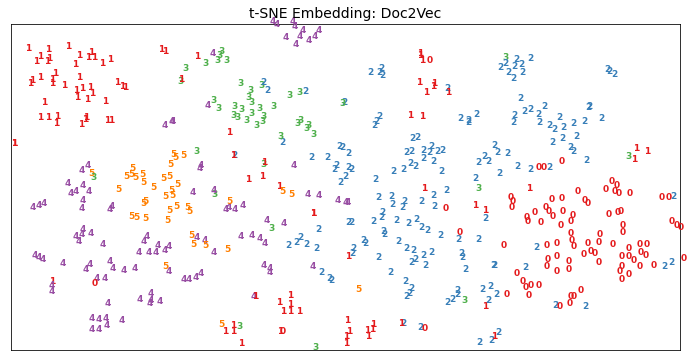

In [59]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(12,6))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(CV_Clusters[i]),color=plt.cm.Set1(CV_Clusters[i] / 10.), 
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title, fontsize=14)

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne,"t-SNE Embedding: Doc2Vec")
plt.savefig('TSNE_Doc2Vec.png')

# Comparison Across Clustering Groups

In [60]:
#Compare how Kmeans clusters compare with original categorization

clustersets=zip(titles, labels, CV_Clusters, TFIDF_Clusters, Doc2Vec_Clusters)
Full_Clusters=pd.DataFrame(clustersets, columns=['titles','labels','CountVec', 'TFIDF', 'Doc2Vec'])
Full_Clusters['counts']=1
Full_Clusters.to_csv('cluster_groups.csv')

Clusters_Crosstab=pd.pivot_table(Full_Clusters, values='counts', index=['labels'], columns=['CountVec'], aggfunc=np.sum)
print(Clusters_Crosstab/Clusters_Crosstab.sum())
print()
Clusters_Crosstab=pd.pivot_table(Full_Clusters, values='counts', index=['labels'], columns=['TFIDF'], aggfunc=np.sum)
print(Clusters_Crosstab/Clusters_Crosstab.sum())
print()
Clusters_Crosstab=pd.pivot_table(Full_Clusters, values='counts', index=['labels'], columns=['Doc2Vec'], aggfunc=np.sum)
print(Clusters_Crosstab/Clusters_Crosstab.sum())

CountVec              0         1         2         3         4         5
labels                                                                   
ethics              NaN  0.510204       NaN       NaN       NaN       NaN
language       0.021978  0.142857  0.378698  0.044444       NaN       NaN
logic          0.252747  0.020408  0.443787       NaN  0.009615       NaN
mathematics    0.692308  0.081633  0.005917       NaN       NaN       NaN
mind                NaN  0.153061  0.029586  0.933333  0.884615  0.128205
phenomenology  0.032967  0.091837  0.142012  0.022222  0.105769  0.871795

TFIDF                 0         1         2         3         4         5
labels                                                                   
ethics              NaN  0.979167       NaN       NaN  0.016667       NaN
language       0.032258       NaN  0.085227       NaN  0.366667       NaN
logic               NaN       NaN  0.511364       NaN  0.061111       NaN
mathematics    0.032258       NaN  0.

In [61]:
Clusters_Crosstab=pd.pivot_table(Full_Clusters, values='counts', index=['CountVec'], columns=['TFIDF'], aggfunc=np.sum)
print(Clusters_Crosstab)
print()
Clusters_Crosstab=pd.pivot_table(Full_Clusters, values='counts', index=['CountVec'], columns=['Doc2Vec'], aggfunc=np.sum)
print(Clusters_Crosstab)
print()
Clusters_Crosstab=pd.pivot_table(Full_Clusters, values='counts', index=['TFIDF'], columns=['Doc2Vec'], aggfunc=np.sum)
print(Clusters_Crosstab)

# Clusters_Crosstab=pd.pivot_table(Full_Clusters, values='counts', index=['CountVec','TFIDF','Doc2Vec'], columns=['labels'], aggfunc=np.sum)
# Clusters_Crosstab

TFIDF        0     1     2     3     4     5
CountVec                                    
0          1.0   NaN  89.0   NaN   1.0   NaN
1          1.0  48.0   1.0   NaN  47.0   1.0
2          NaN   NaN  84.0   NaN  85.0   NaN
3          NaN   NaN   1.0   1.0  40.0   3.0
4         29.0   NaN   1.0   2.0   7.0  65.0
5          NaN   NaN   NaN  34.0   NaN   5.0

Doc2Vec      0     1     2     3     4     5
CountVec                                    
0          1.0   NaN   1.0  42.0   NaN  47.0
1          4.0  10.0   1.0  18.0  65.0   NaN
2          1.0  54.0  72.0  34.0   NaN   8.0
3          9.0  30.0   1.0   3.0   2.0   NaN
4         91.0  10.0   1.0   1.0   NaN   1.0
5         37.0   1.0   NaN   1.0   NaN   NaN

Doc2Vec     0     1     2     3     4     5
TFIDF                                      
0        30.0   1.0   NaN   NaN   NaN   NaN
1         NaN   NaN   NaN   NaN  48.0   NaN
2         NaN   2.0  60.0  58.0   NaN  56.0
3        34.0   2.0   NaN   1.0   NaN   NaN
4        13.0 

In [62]:
#Overall Group Distributions:
print('Overall')
print(Full_Clusters['labels'].value_counts())
print('\nTFIDF')
print(Full_Clusters['TFIDF'].value_counts())
print('\nTerm Document')
print(Full_Clusters['CountVec'].value_counts())
print('\nDoc2Vec')
print(Full_Clusters['Doc2Vec'].value_counts())

Overall
mind             159
logic            101
language          82
phenomenology     82
mathematics       72
ethics            50
Name: labels, dtype: int64

TFIDF
4    180
2    176
5     74
1     48
3     37
0     31
Name: TFIDF, dtype: int64

Term Document
2    169
4    104
1     98
0     91
3     45
5     39
Name: CountVec, dtype: int64

Doc2Vec
0    143
1    105
3     99
2     76
4     67
5     56
Name: Doc2Vec, dtype: int64


In [63]:
ismind=Full_Clusters['labels']=='mathematics'
Full_Clusters[ismind].head(15)

,titles,labels,CountVec,TFIDF,Doc2Vec,counts
12,Luitzen Egbertus Jan Brouwer_1 The Person.txt,mathematics,0,2,3,1
20,Interpretations of Probability_4 Conclusion Re...,mathematics,1,4,1,1
23,Philosophy of Mathematics_6 The Future.txt,mathematics,0,2,5,1
26,Set Theory_6 The set theory of the continuum.txt,mathematics,0,2,5,1
28,Formalism in the Philosophy of Mathematics_3 T...,mathematics,0,4,3,1
31,Formalism in the Philosophy of Mathematics_1 I...,mathematics,0,2,3,1
34,The Frege Hilbert Controversy_1 Introduction.txt,mathematics,0,2,3,1
36,Set Theory_1 The origins.txt,mathematics,0,2,5,1
39,Bernard Bolzano_2 Bolzanos Main Writings.txt,mathematics,0,2,3,1
45,Type Theory_4 Type TheorySet Theory.txt,mathematics,0,2,5,1


# LDiA 

word matrix ldia shape:  (23612, 6)


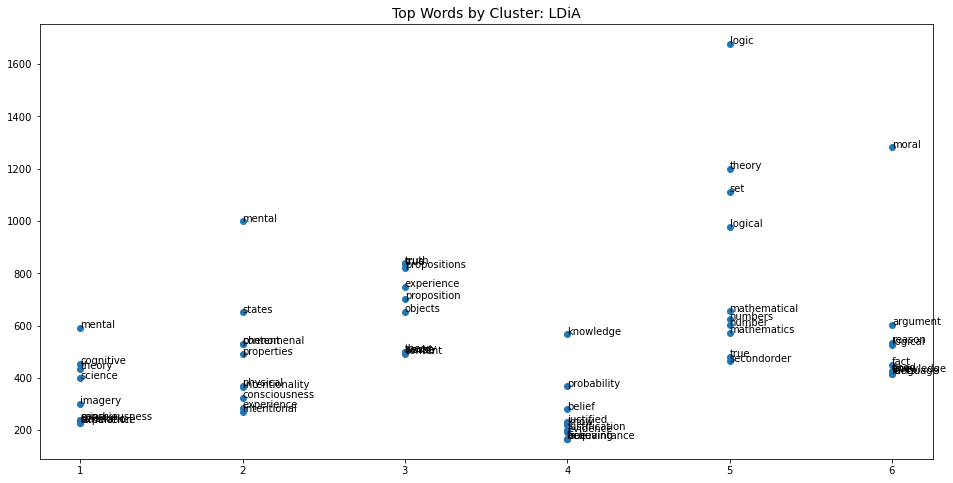

In [64]:
#LDiA

latent_vars=6

cv=CountVectorizer()
bow_docs=pd.DataFrame(cv.fit_transform(raw_documents=X_corp).toarray())
col_nums, terms=zip(*sorted(zip(cv.vocabulary_.values(),cv.vocabulary_.keys())))
bow_docs.columns=terms

ldia=LDiA(n_components=latent_vars, learning_method='batch')
ldia=ldia.fit(bow_docs)
ldia6_topic_vectors=ldia.transform(bow_docs)

columns=['topic'+str(x) for x in np.arange(1,latent_vars+1)]
ldia6_topic_vectors_df=pd.DataFrame(ldia.components_, columns=cv.get_feature_names()).T
print('word matrix ldia shape: ', ldia6_topic_vectors_df.shape)

ldia_vecs10={}
for col in ldia6_topic_vectors_df.columns:
    intldia=ldia6_topic_vectors_df.nlargest(10,col)
    ldia_vecs=list(zip(intldia.index.to_list(),intldia[col].to_list()))
    ldia_vecs10[col]=[ldia_vecs]

x,y,wlabel=[],[],[]
counter=0
for item in ldia_vecs10.values():
    counter=counter+1
    for word in item:
        for ww,wv in word:
            x.append(counter)
            y.append(wv)
            wlabel.append(ww)
            
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x, y)
for i, txt in enumerate(wlabel):
    ax.annotate(txt, (x[i], y[i]), fontsize=10)
plt.title('Top Words by Cluster: LDiA', fontsize=14)
plt.savefig('LDiA.png')

# Terms as Objects
## t-SNE for Term-Document, TF-IDF Matrices

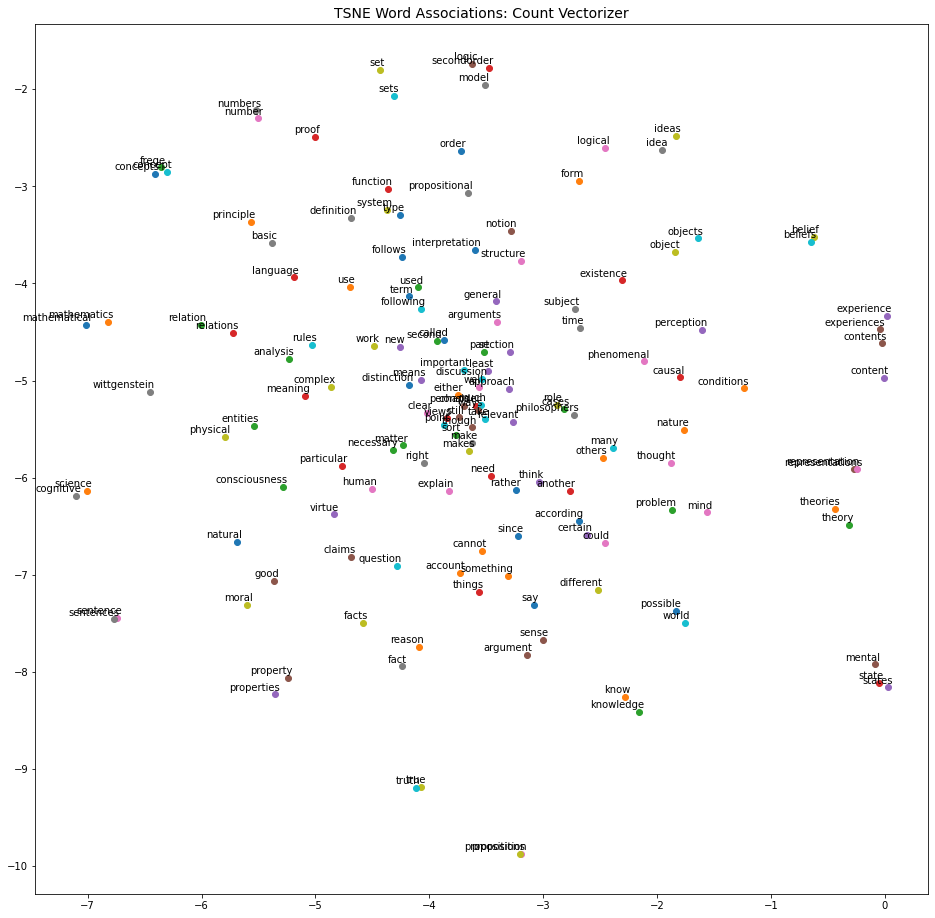

In [65]:
#t-SNE plot of term document matrix

def tsne_plot(wordcount):
    topwords=[]
    for item in corp_words.most_common(wordcount):
        topwords.append(item[0])
    X_top_tokens=[]
    for doc in X_corp:
        tokens=doc.split()
        tokens=[w for w in tokens if w in topwords]
        wtokens=' '.join(tokens)
        X_top_tokens.append(wtokens)

    CV=CountVectorizer()
    cv_topw=CV.fit_transform(X_top_tokens)
    labels=CV.get_feature_names()
    tokens=[]
    for line in cv_topw.T.toarray():
        tokens.append(line)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)
    x,y = [],[]
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points',ha='right',va='bottom')
    plt.title('TSNE Word Associations: Count Vectorizer', fontsize=14)
    plt.show()
    
tsne_plot(150)

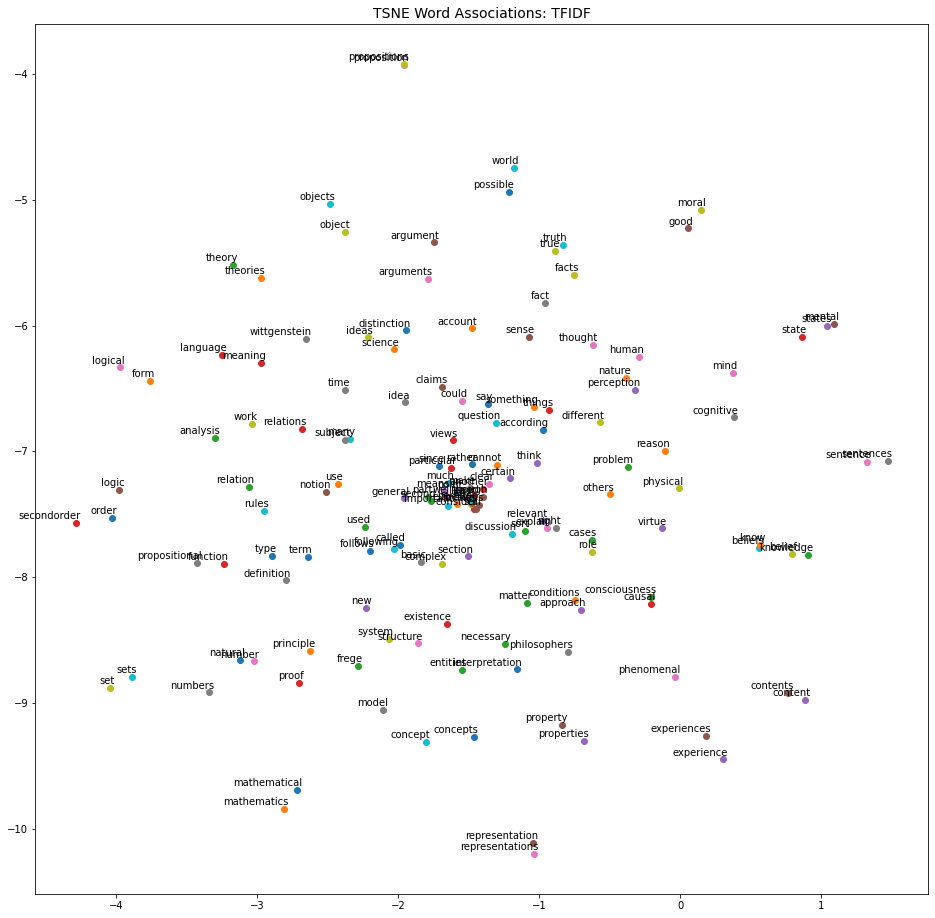

In [66]:
#t-SNE plot of TFIDF matrix

def tsne_plot(wordcount):
    topwords=[]
    for item in corp_words.most_common(wordcount):
        topwords.append(item[0])
    X_top_tokens=[]
    for doc in X_corp:
        tokens=doc.split()
        tokens=[w for w in tokens if w in topwords]
        wtokens=' '.join(tokens)
        X_top_tokens.append(wtokens)

    TFIDF=TfidfVectorizer()
    TFIDF_topw=TFIDF.fit_transform(X_top_tokens)
    labels=TFIDF.get_feature_names()
    tokens=[]
    for line in TFIDF_topw.T.toarray():
        tokens.append(line)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)
    x,y = [],[]
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points',ha='right',va='bottom')
    plt.title('TSNE Word Associations: TFIDF', fontsize=14)
    plt.show()
    
tsne_plot(150)

/home/meeka/miniconda3/envs/language/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


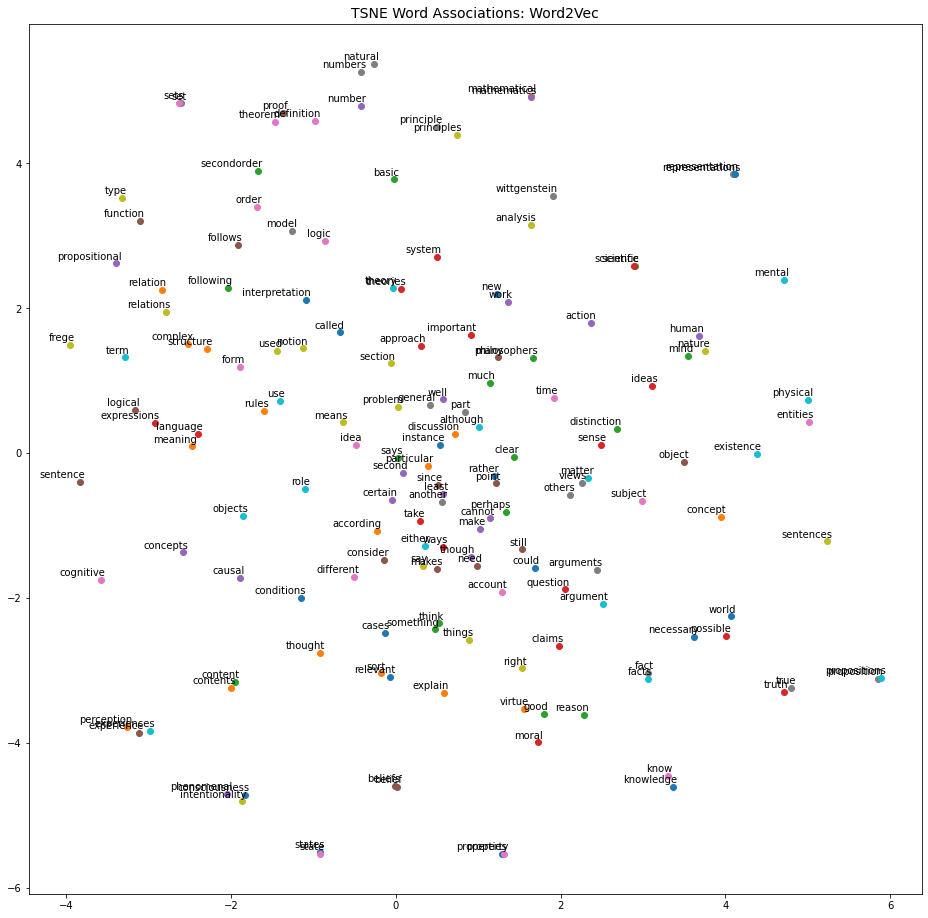

In [67]:
from gensim.models import word2vec

def tokenize_docs(X):
    word_tokens=[]
    for doc in X:
        tokens=doc.split()
        word_tokens.append(tokens)
    return word_tokens
    
X_train_tokens=tokenize_docs(X_corp)

model = word2vec.Word2Vec(X_train_tokens, size=150, window=20, min_count=400, workers=4)

def tsne_plot(model):
    labels,tokens = [],[]
    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x,y = [],[]
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points',ha='right',va='bottom')
    plt.title('TSNE Word Associations: Word2Vec', fontsize=14)
    plt.show()
tsne_plot(model)

In [68]:
model.most_similar('nature')

/home/meeka/miniconda3/envs/language/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('human', 0.8243874311447144),
 ('mind', 0.6790307760238647),
 ('others', 0.6773407459259033),
 ('matter', 0.6734256744384766),
 ('rather', 0.6637075543403625),
 ('perception', 0.6417648792266846),
 ('physical', 0.6222629547119141),
 ('scientific', 0.5843324661254883),
 ('science', 0.5810402631759644),
 ('part', 0.5727994441986084)]

# Hierarchical Clustering

In [69]:
topwords=[]
for item in corp_words.most_common(100):
    topwords.append(item[0])
X_top_tokens=[]
for doc in X_corp:
    tokens=doc.split()
    tokens=[w for w in tokens if w in topwords]
    wtokens=' '.join(tokens)
    X_top_tokens.append(wtokens)

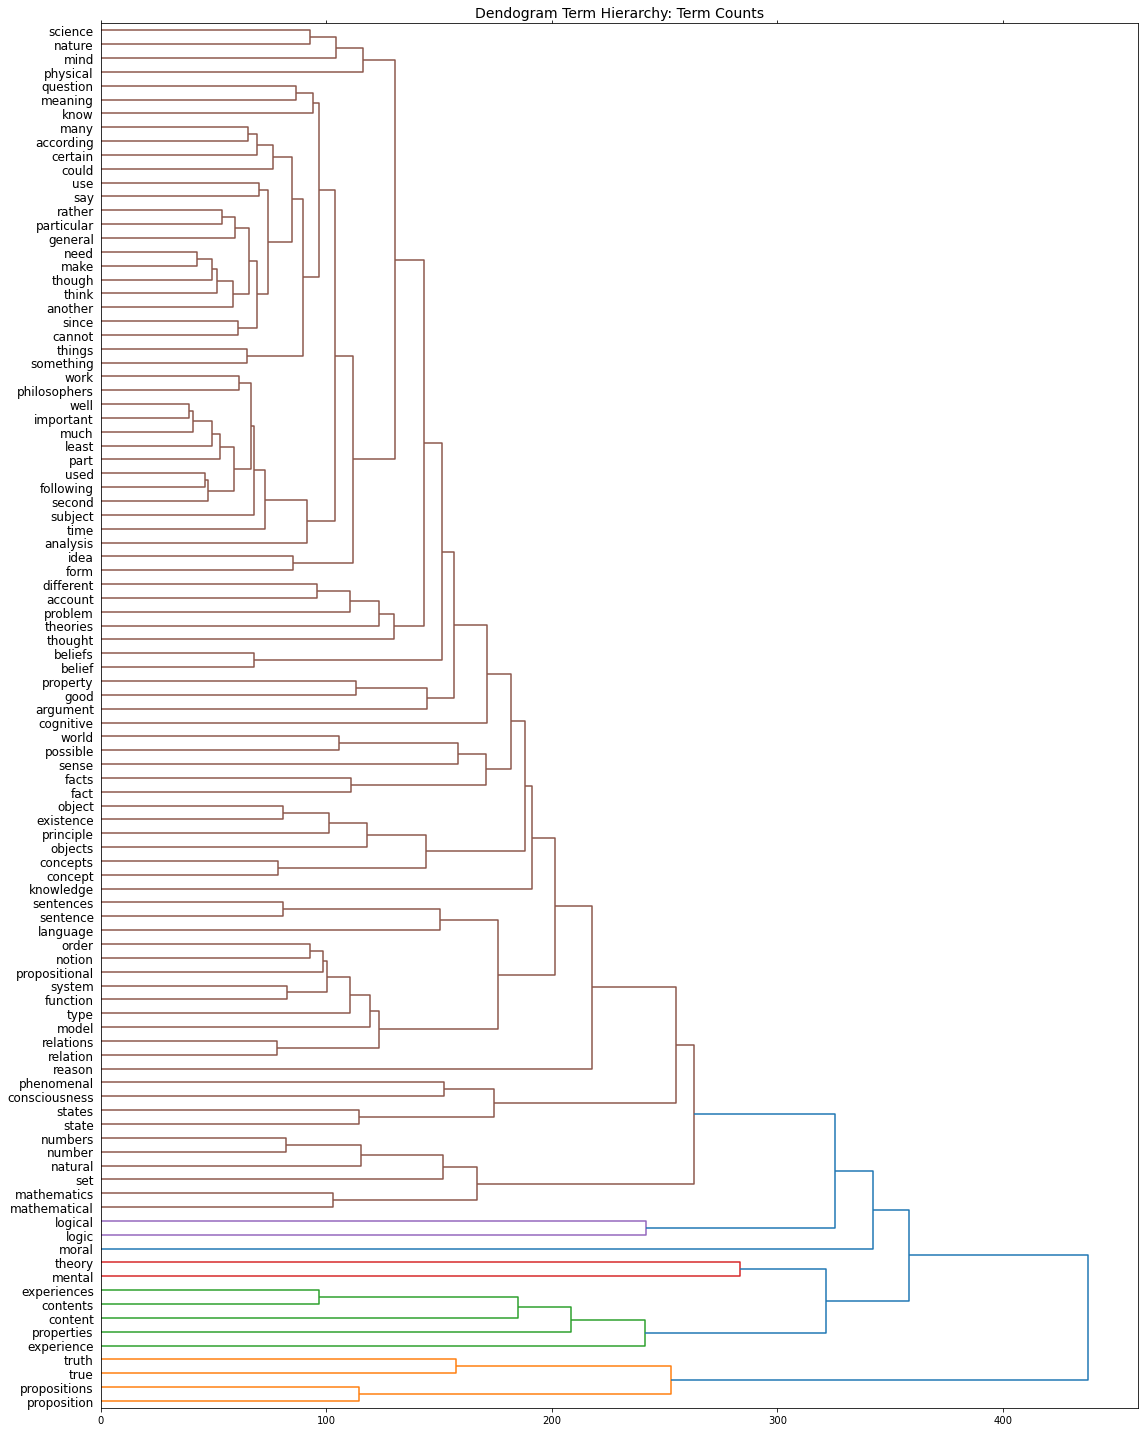

In [70]:
#Term Document Hierarchical Clustering

CV=CountVectorizer()
CV_topw=CV.fit_transform(X_top_tokens)
labels=CV.get_feature_names()
tokens=[]
for line in CV_topw.T.toarray():
    tokens.append(line)
    
linkage_matrix = ward(tokens)
fig, ax = plt.subplots(figsize=(16, 20))
ax = dendrogram(linkage_matrix, orientation="right", labels=labels)

plt.tick_params(axis= 'x',which='both',bottom='off',top='off',labelbottom='off')
plt.tick_params(axis= 'y',labelsize=12)
plt.title('Dendogram Term Hierarchy: Term Counts', fontsize=14)
plt.tight_layout()
plt.savefig('Dend_CV.png')

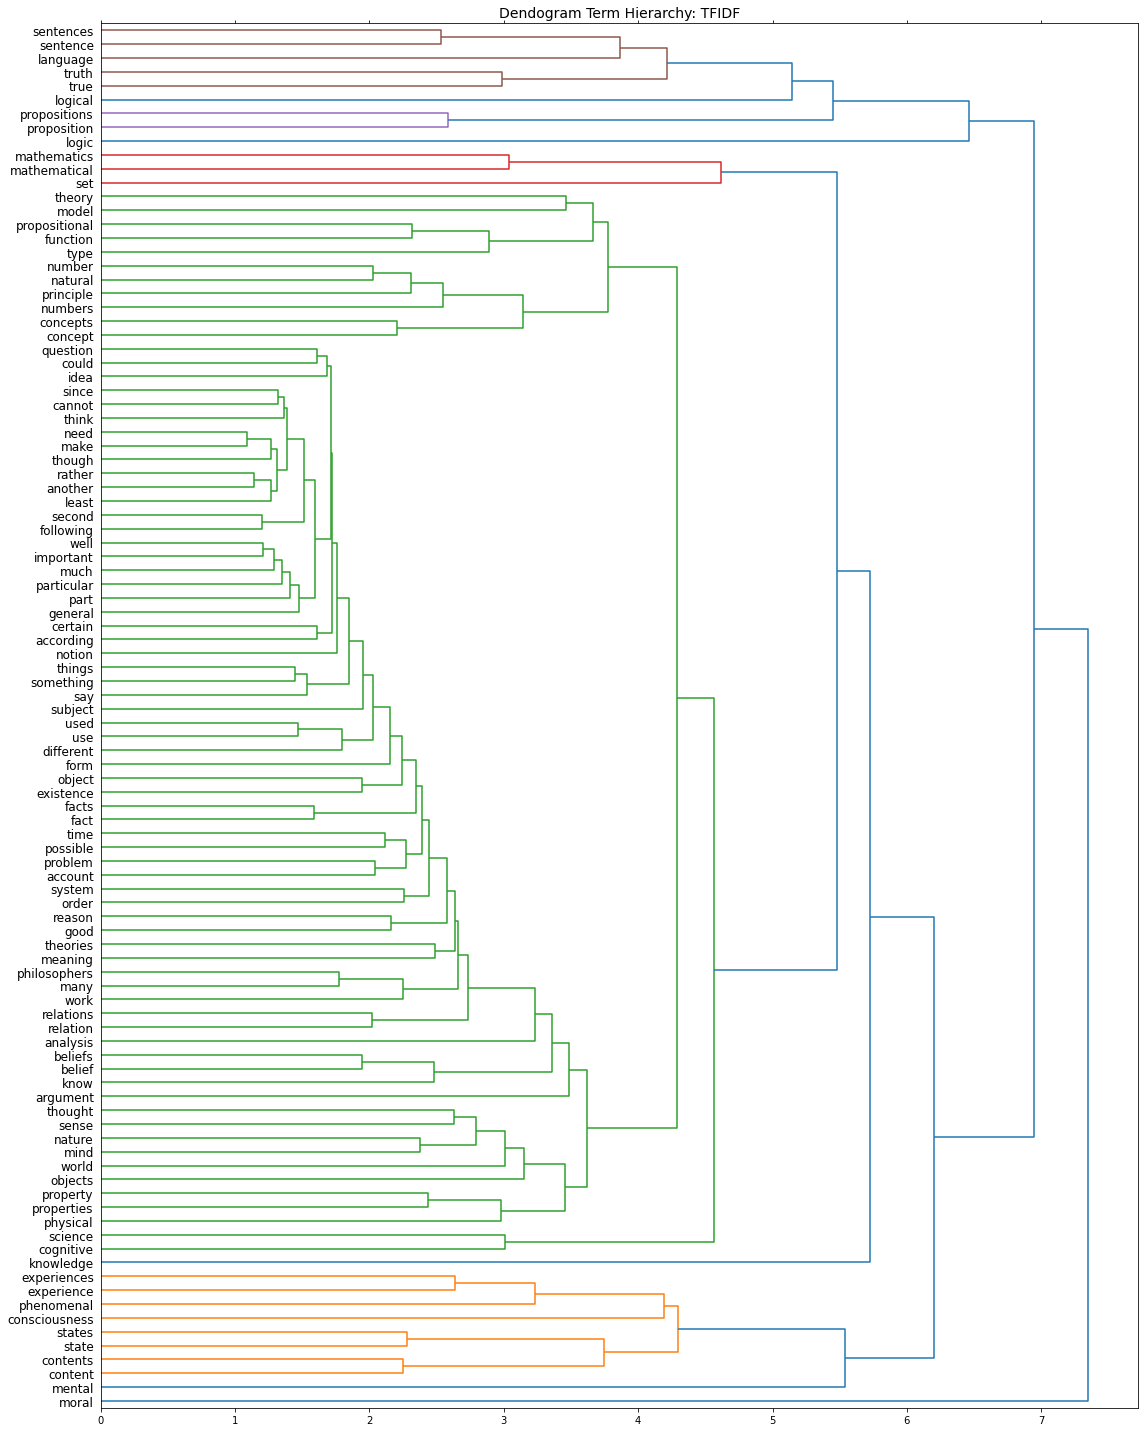

In [71]:
#TF-IDF Hierarchical Clustering

TFIDF=TfidfVectorizer()
TFIDF_topw=TFIDF.fit_transform(X_top_tokens)
labels=TFIDF.get_feature_names()
tokens=[]
for line in TFIDF_topw.T.toarray():
    tokens.append(line)
    
linkage_matrix = ward(tokens)
fig, ax = plt.subplots(figsize=(16, 20))
ax = dendrogram(linkage_matrix, orientation="right", labels=labels)

plt.tick_params(axis= 'x',which='both',bottom='off',top='off',labelbottom='off')
plt.tick_params(axis= 'y',labelsize=12)
plt.title('Dendogram Term Hierarchy: TFIDF', fontsize=14)
plt.tight_layout()
plt.savefig('Dend_TFIDF.png')

##  Word Covariance Matrix 

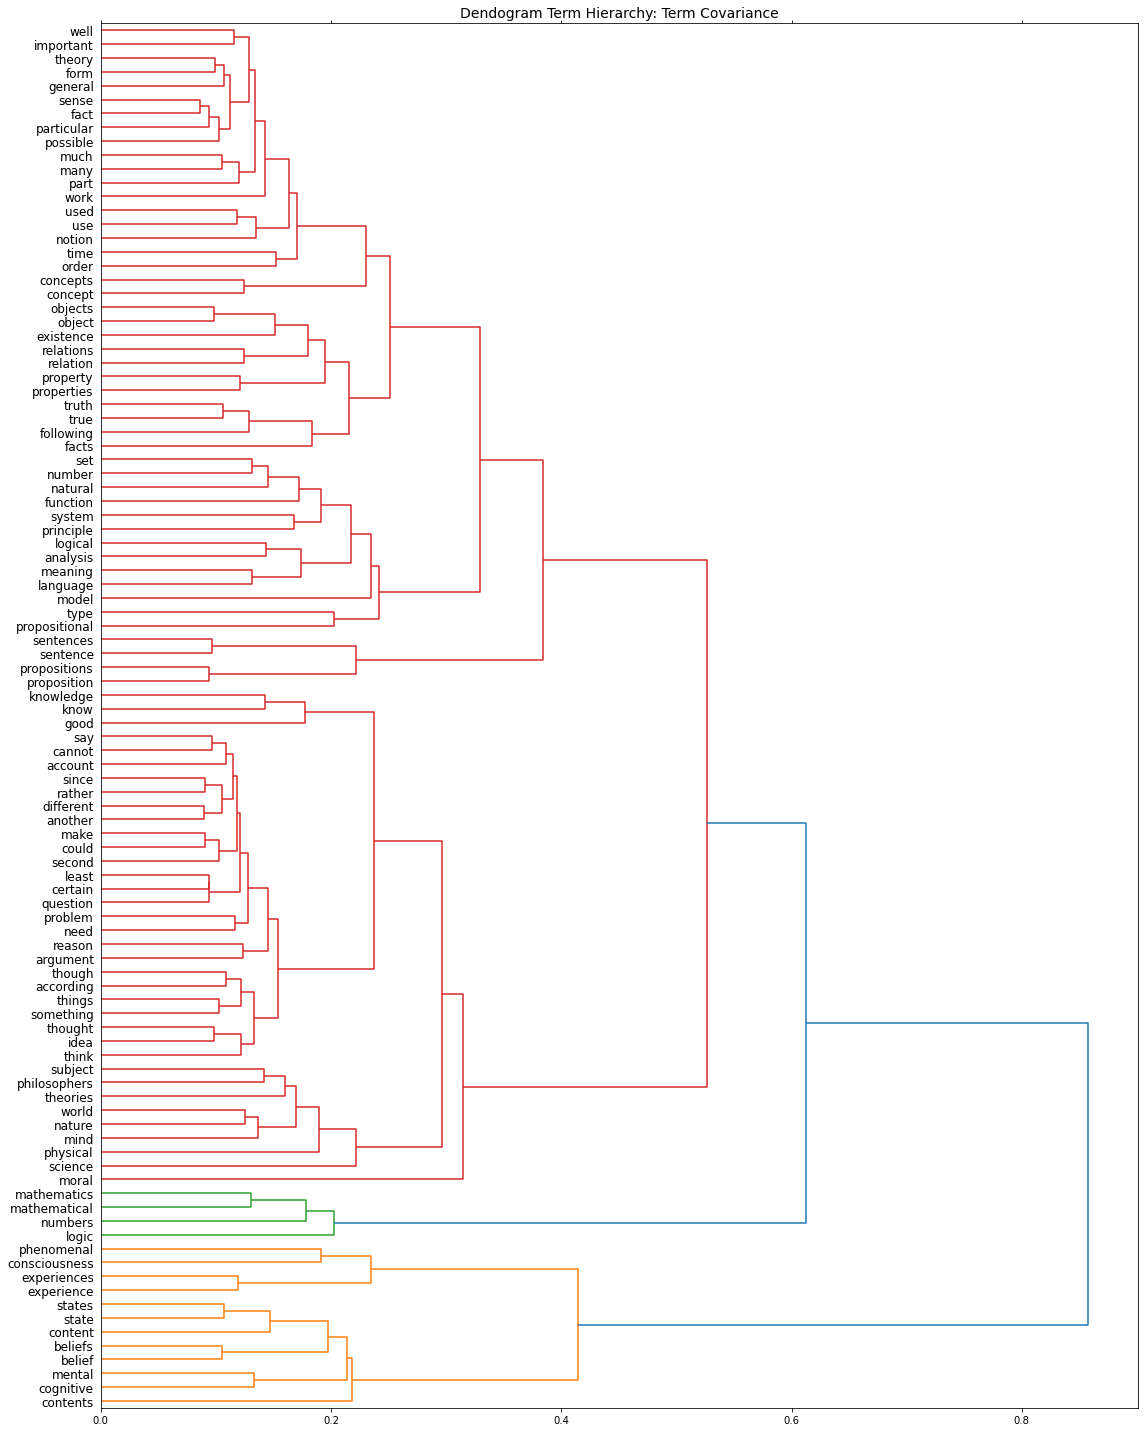

In [72]:
#Term Document Covariance Based Hierarchical Clustering
#With Normalization

vectorizer=CountVectorizer()
X=vectorizer.fit_transform(X_top_tokens).todense()
X[X > 0] = 1
Xc = (X.T * X)

normalizer=Normalizer()
Xc_norm=normalizer.fit_transform(Xc)
Xc_norm
    
linkage_matrix = ward(Xc_norm)
fig, ax = plt.subplots(figsize=(16, 20))
ax = dendrogram(linkage_matrix, orientation="right", labels=labels)

plt.tick_params(axis= 'x',which='both',bottom='off',top='off',labelbottom='off')
plt.tick_params(axis= 'y',labelsize=12)
plt.title('Dendogram Term Hierarchy: Term Covariance', fontsize=14)
plt.tight_layout()
plt.savefig('Dend_Cov_Normal.png')

In [74]:
top1kw=[]
for item in corp_words.most_common(150):
    top1kw.append(item[0])
    
slimcorp=[]
for text in X_corp:
    tokens=text.split()
    tokens=[w for w in tokens if w in top1kw]
    wtokens=' '.join(tokens)
    slimcorp.append(wtokens)
    
vectorizer=CountVectorizer()
X=vectorizer.fit_transform(slimcorp).todense()
X[X > 0] = 1
Xc = (X.T * X)

labels=vectorizer.get_feature_names()
co_occ_df=pd.DataFrame(Xc, columns=labels, index=labels)
co_occ_df.head()

,according,account,analysis,another,approach,argument,arguments,basic,belief,beliefs,...,type,use,used,views,virtue,ways,well,wittgenstein,work,world
according,274,167,106,187,116,140,113,109,111,98,...,78,165,149,120,97,134,178,38,151,149
account,167,268,106,175,115,139,112,102,106,92,...,74,162,138,114,88,140,176,37,155,151
analysis,106,106,175,115,71,92,68,70,66,42,...,55,103,103,71,49,77,101,33,97,83
another,187,175,115,300,130,159,120,121,112,97,...,85,199,163,123,91,147,186,45,166,163
approach,116,115,71,130,186,96,73,76,73,60,...,56,119,93,78,64,104,116,27,120,92
